In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [2]:
url='http://nagyvofely.hu/Budapest/irszam'
res = requests.get(url)
res = BeautifulSoup(res.content,'lxml')

data = res.findAll('fieldset')

In [3]:
postal_code=[d.find('a').text for d in data]
district=[d.find('a')['title'].replace(' ', '').split(',')[1].split('.')[0] for d in data]

In [4]:
df=pd.DataFrame()
df['PostalCode']=postal_code
df['Neighborhood']=district
df.tail(10)

,PostalCode,Neighborhood
151,1214,XXI
152,1215,XXI
153,1221,XXII
154,1222,XXII
155,1223,XXII
156,1224,XXII
157,1225,XXII
158,1237,XXIII
159,1238,XXIII
160,1239,XXIII


In [5]:
url_temp='https://xn--irnytszmok-t4af6mnd.cybo.com/magyarorsz%C3%A1g/postal_budapest-x.-ker%C3%BClet/'

lat=[]
lon=[]
for postal in df['PostalCode']:
    url=url_temp.replace('postal', str(postal))
    res = requests.get(url)
    res = BeautifulSoup(res.content,'lxml')

    table=res.find('table')
    rows=table.findAll('tr')

    for r in rows:
        cells=r.findAll('td')
        if cells[0].text=='Koordináták':
            coords=cells[1].text.split('/')
            lat.append(coords[0].replace('°','').replace(' ', ''))
            lon.append(coords[1].replace('°','').replace(' ',''))

In [6]:
df['Borough.Latitude']=lat
df['Borough.Longitude']=lon
df.head()

,PostalCode,Neighborhood,Borough.Latitude,Borough.Longitude
0,1011,I,47.50730454130059,19.03893593192484
1,1012,I,47.4997356790391,19.02816805968499
2,1013,I,47.49458714651173,19.040202587219362
3,1014,I,47.50245452032449,19.031893910668916
4,1015,I,47.505254105173194,19.03310818237037


In [7]:
url='https://en.m.wikipedia.org/wiki/List_of_districts_in_Budapest'

#res=requests.get(url)
#res=BeautifulSoup(res.content, 'lxml')
#table=res.find('table')
df2=pd.read_html(url, skiprows=1)[0]
df2.head()

,0,1,2,3
0,I.,Várkerület(Castle District),"Buda Castle, Tabán, Gellérthegy, Krisztinaváro...","Buda Castle, Matthias Church, Hungarian Nation..."
1,II.,none,"Adyliget, Budakeszierdő, Budaliget, Csatárka, ...","Tomb of Gül Baba, Mechwart Park, Cave of Szeml..."
2,III.,Óbuda-Békásmegyer,"Óbuda, Aquincum, Aranyhegy, Békásmegyer, Csill...","Ruins of Aquincum, Aquincum Military Amphithea..."
3,IV.,Újpest(New Pest),"Újpest, Megyer, Káposztásmegyer, Székesdűlő, I...","Queen of Heavens Church, Synagogue of Újpest, ..."
4,V.,Belváros-Lipótváros(Inner City-Leopold Town),"Inner City, Lipótváros","Parliament, Hungarian Academy of Sciences, Gre..."


In [8]:
df3=pd.DataFrame() 
df3['Neighborhood']=df2[0].apply(lambda x: x.replace('.','').replace(' kerület',''))
df3['Borough']=df2[2]
df3.drop(df3.index[-1], inplace=True)
df3.head()

,Neighborhood,Borough
0,I,"Buda Castle, Tabán, Gellérthegy, Krisztinaváro..."
1,II,"Adyliget, Budakeszierdő, Budaliget, Csatárka, ..."
2,III,"Óbuda, Aquincum, Aranyhegy, Békásmegyer, Csill..."
3,IV,"Újpest, Megyer, Káposztásmegyer, Székesdűlő, I..."
4,V,"Inner City, Lipótváros"


In [9]:
coords='47.4979° N, 19.0402° E, 47.5393° N, 18.9869° E, 47.5672° N, 19.0369° E, 47.5649° N, 19.0913° E, 47.5002° N, 19.0520° E, 47.5099° N, 19.0626° E, 47.5027° N, 19.0734° E, 47.4894° N, 19.0707° E, 47.4649° N, 19.0916° E, 47.4833° N, 19.1573° E, 47.4593° N, 19.0187° E, 47.4991° N, 18.9905° E, 47.5355° N, 19.0709° E, 47.5225° N, 19.1147° E, 47.5589° N, 19.1193° E, 47.5183° N, 19.1919° E, 47.4803° N, 19.2667° E, 47.4281° N, 19.2098° E, 47.4457° N, 19.1430° E, 47.4333° N, 19.1193° E, 47.4244° N, 19.0661° E, 47.4250° N, 19.0317° E, 47.3940° N, 19.1225° E'
coords=coords.replace('° E', '').replace('° N', '').split(', ')
df3['Neighborhood.Latitude']=coords[::2]
df3['Neighborhood.Longitude']=coords[1::2]
df3

,Neighborhood,Borough,Neighborhood.Latitude,Neighborhood.Longitude
0,I,"Buda Castle, Tabán, Gellérthegy, Krisztinaváro...",47.4979,19.0402
1,II,"Adyliget, Budakeszierdő, Budaliget, Csatárka, ...",47.5393,18.9869
2,III,"Óbuda, Aquincum, Aranyhegy, Békásmegyer, Csill...",47.5672,19.0369
3,IV,"Újpest, Megyer, Káposztásmegyer, Székesdűlő, I...",47.5649,19.0913
4,V,"Inner City, Lipótváros",47.5002,19.0520
5,VI,Terézváros,47.5099,19.0626
6,VII,Erzsébetváros,47.5027,19.0734
7,VIII,"Józsefváros, Kerepesdűlő, Tisztviselőtelep",47.4894,19.0707
8,IX,"Ferencváros, Gubacsidűlő, József Attila-lakótelep",47.4649,19.0916
9,X,"Felsőrákos, Gyárdűlő, Keresztúridűlő, Kőbánya-...",47.4833,19.1573


In [10]:
merged = pd.merge(left=df3, right=df, left_on='Neighborhood', right_on='Neighborhood')
merged.tail()

,Neighborhood,Borough,Neighborhood.Latitude,Neighborhood.Longitude,PostalCode,Borough.Latitude,Borough.Longitude
156,XXII,"Budatétény, Nagytétény, Budafok",47.4250,19.0317,1224,47.41272556201547,18.981238523749276
157,XXII,"Budatétény, Nagytétény, Budafok",47.4250,19.0317,1225,47.3914886662968,18.97916949242869
158,XXIII,Soroksár,47.3940,19.1225,1237,47.41893101854791,19.120036680983922
159,XXIII,Soroksár,47.3940,19.1225,1238,47.387640049162016,19.14947643654811
160,XXIII,Soroksár,47.3940,19.1225,1239,47.3859041254757,19.11623283473755


In [11]:
!pip install folium
import folium

In [12]:
bp_lat='47.48'
bp_lon='19.13'

line_points=[
    (47.3850,19.0320),
    (47.5850,19.0580)
]

map=folium.Map(location=[bp_lat, bp_lon], zoom_start=11)

folium.PolyLine(line_points, color='blue', weight=5, opacity=1).add_to(map)

folium.map.Marker(
    [47.5850, 19.0200],
    icon=folium.DivIcon(
        icon_size=(15,15),
        icon_anchor=(0,0),
        html='<b style="font-size: 16pt;">Buda</b>'
        )
    ).add_to(map)
folium.map.Marker(
    [47.5850, 19.0600],
    icon=folium.DivIcon(
        icon_size=(15,15),
        icon_anchor=(0,0),
        html='<b style="font-size: 16pt;">Pest</b>',
        )
    ).add_to(map)

for lat, lon, label in zip(df3['Neighborhood.Latitude'], df3['Neighborhood.Longitude'], df3['Neighborhood']):
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon], 
        radius=5,
        color='red',
        popup=label,
        fill=True,
        fill_color='#500000',
        fill_opacity=0.7,
        parse_html=False).add_to(map)

map

In [13]:
# The code was removed by Watson Studio for sharing.

In [14]:
CLIENT_ID='YOUR_ID'
CLIENT_SECRET='YOUR_SECRET'
VERSION='20180605'
LIMIT=300
RADIUS=1000

In [15]:
# The code was removed by Watson Studio for sharing.

In [16]:
def getNearbyVenues(names, lats, lons):
    list=[]
    for n, la, lo in zip(names, lats, lons):
        url= 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, la, lo, RADIUS, LIMIT)
        results= requests.get(url).json()['response']['groups'][0]['items']
        list.append([(
         n, 
         la, 
         lo, 
         v['venue']['name'], 
         v['venue']['location']['lat'], 
         v['venue']['location']['lng'], 
         v['venue']['categories'][0]['name']) for v in results]
        )
    
    nearby=pd.DataFrame([item for vlist in list for item in vlist])
    nearby.columns=[
     'Neighborhood',
     'Neighborhood Latitude', 
     'Neighborhood Longitude',
     'Venue',
     'Venue Latitude',
     'Venue Longitude', 
     'Venue Category'
    ]

    return(nearby)

In [17]:
venues=getNearbyVenues(
  names=df3['Neighborhood'],
  lats=df3['Neighborhood.Latitude'],
  lons=df3['Neighborhood.Longitude']
)
print(venues.shape)

(1177, 7)


In [18]:
onehot=pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
onehot['Neighborhood']=venues['Neighborhood']
fixed_columns=[onehot.columns[-1]]+list(onehot.columns[:-1])
onehot=onehot[fixed_columns]
grouped=onehot.groupby('Neighborhood').mean().reset_index()
print(grouped.shape)

(23, 220)


In [19]:
def most_common_venues(row, top):
    row_categories=row.iloc[1:]
    row_categories_sorted= row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:top]

In [20]:
import numpy as np

In [21]:
top=10
indicators=['st', 'nd', 'rd']
columns=['Neighborhood']
for ind in np.arange(top):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicator[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

sorted=pd.DataFrame(columns=columns)
sorted['Neighborhood']=grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    sorted.iloc[ind, 1:]=most_common_venues(grouped.iloc[ind, :],top)

sorted.head()

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I,Hotel,Coffee Shop,Plaza,Hungarian Restaurant,Scenic Lookout,Café,Bistro,Restaurant,Italian Restaurant,Wine Bar
1,II,Park,Tram Station,Tennis Court,Scenic Lookout,Athletics & Sports,American Restaurant,Forest,Campground,Soccer Field,Track
2,III,Bus Stop,Train Station,Deli / Bodega,Track,Hungarian Restaurant,Karaoke Bar,Heliport,Mountain,Other Repair Shop,Plaza
3,IV,Bus Stop,Fast Food Restaurant,Bakery,Café,Dessert Shop,Grocery Store,Tram Station,Bar,Park,Gastropub
4,IX,Soccer Field,Furniture / Home Store,Bus Station,Mobile Phone Shop,Dance Studio,Tram Station,Train Station,Gym / Fitness Center,Hungarian Restaurant,Clothing Store


In [22]:
from sklearn.cluster import KMeans
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

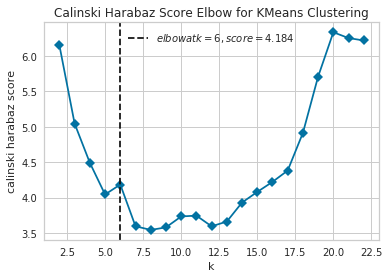

In [36]:
clustering=grouped.drop('Neighborhood', 1)

visualizer = KElbowVisualizer(KMeans(), k=(2,23), metric='calinski_harabasz', timings=False)
visualizer.fit(clustering)
visualizer.show() 

In [37]:
# The code was removed by Watson Studio for sharing.

In [25]:
k=6
kmeans=KMeans(n_clusters=k, random_state=0)
kmeans.fit(clustering)

clustered=sorted
clustered.insert(0,'Cluster Labels', kmeans.labels_)

merged=df3
merged=merged.join(sorted.set_index('Neighborhood'), on='Neighborhood')
merged

,Neighborhood,Borough,Neighborhood.Latitude,Neighborhood.Longitude,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I,"Buda Castle, Tabán, Gellérthegy, Krisztinaváro...",47.4979,19.0402,2,Hotel,Coffee Shop,Plaza,Hungarian Restaurant,Scenic Lookout,Café,Bistro,Restaurant,Italian Restaurant,Wine Bar
1,II,"Adyliget, Budakeszierdő, Budaliget, Csatárka, ...",47.5393,18.9869,3,Park,Tram Station,Tennis Court,Scenic Lookout,Athletics & Sports,American Restaurant,Forest,Campground,Soccer Field,Track
2,III,"Óbuda, Aquincum, Aranyhegy, Békásmegyer, Csill...",47.5672,19.0369,1,Bus Stop,Train Station,Deli / Bodega,Track,Hungarian Restaurant,Karaoke Bar,Heliport,Mountain,Other Repair Shop,Plaza
3,IV,"Újpest, Megyer, Káposztásmegyer, Székesdűlő, I...",47.5649,19.0913,4,Bus Stop,Fast Food Restaurant,Bakery,Café,Dessert Shop,Grocery Store,Tram Station,Bar,Park,Gastropub
4,V,"Inner City, Lipótváros",47.5002,19.0520,2,Hotel,Coffee Shop,Italian Restaurant,Hungarian Restaurant,Plaza,Restaurant,Ice Cream Shop,Pizza Place,Café,Modern European Restaurant
5,VI,Terézváros,47.5099,19.0626,2,Coffee Shop,Italian Restaurant,Pizza Place,Ice Cream Shop,Café,Theater,Hotel,Sporting Goods Shop,Bar,Vietnamese Restaurant
6,VII,Erzsébetváros,47.5027,19.0734,2,Coffee Shop,Hotel,Bar,Restaurant,Hungarian Restaurant,Burger Joint,Theater,Beer Bar,Bakery,Ice Cream Shop
7,VIII,"Józsefváros, Kerepesdűlő, Tisztviselőtelep",47.4894,19.0707,2,Coffee Shop,Hotel,Bar,Italian Restaurant,Burger Joint,Electronics Store,Gastropub,Ice Cream Shop,Wine Bar,Gym / Fitness Center
8,IX,"Ferencváros, Gubacsidűlő, József Attila-lakótelep",47.4649,19.0916,0,Soccer Field,Furniture / Home Store,Bus Station,Mobile Phone Shop,Dance Studio,Tram Station,Train Station,Gym / Fitness Center,Hungarian Restaurant,Clothing Store
9,X,"Felsőrákos, Gyárdűlő, Keresztúridűlő, Kőbánya-...",47.4833,19.1573,5,Tram Station,Park,Pub,Fast Food Restaurant,Supermarket,Brewery,Paper / Office Supplies Store,Track,Gym,Sporting Goods Shop


In [26]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [51]:
map=folium.Map(location=[bp_lat, bp_lon], zoom_start=11)

folium.PolyLine(line_points, color='blue', weight=5, opacity=1).add_to(map)

folium.map.Marker(
    [47.5850, 19.0200],
    icon=folium.DivIcon(
        icon_size=(15,15),
        icon_anchor=(0,0),
        html='<b style="font-size: 16pt;">Buda</b>'
        )
    ).add_to(map)
folium.map.Marker(
    [47.5850, 19.0600],
    icon=folium.DivIcon(
        icon_size=(15,15),
        icon_anchor=(0,0),
        html='<b style="font-size: 16pt;">Pest</b>'
        )
    ).add_to(map)

x=np.arange(k)
ys=[i+x+(i*x)**2 for i in range(k)]
colors_array=cm.rainbow(np.linspace(0,1,len(ys)))
rainbow=[colors.rgb2hex(i) for i in colors_array]

markers_colors=[]

for lat, lon, poi, clus in zip(merged['Neighborhood.Latitude'], merged['Neighborhood.Longitude'], merged['Neighborhood'], merged['Cluster Labels']):
    label=folium.Popup(str(poi)+' Cluster '+str(clus), parse_html=True)
    folium.CircleMarker(
        [lat, lon], 
        radius=5,
        color=rainbow[clus-1], 
        popup=label,
        fill=True,
        fill_color=rainbow[clus-1], 
        fill_opacity=0.7).add_to(map)
    folium.Circle(
        [lat, lon],
        radius=RADIUS,
        color='green',  
        fill=False).add_to(map)
                                        
map

In [28]:
# The code was removed by Watson Studio for sharing.

In [38]:
merged.loc[merged['Cluster Labels']==0, merged.columns[[0]+list(range(k-1, merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,IX,Soccer Field,Furniture / Home Store,Bus Station,Mobile Phone Shop,Dance Studio,Tram Station,Train Station,Gym / Fitness Center,Hungarian Restaurant,Clothing Store
12,XIII,Gym / Fitness Center,Coffee Shop,Grocery Store,Pub,Supermarket,Gym,Indian Restaurant,Electronics Store,Park,Chinese Restaurant
20,XXI,Grocery Store,Gym,Fast Food Restaurant,Pizza Place,Beer Garden,Soccer Field,Restaurant,Bus Stop,Soccer Stadium,Movie Theater


In [39]:
merged.loc[merged['Cluster Labels']==1, merged.columns[[0]+list(range(k-1, merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,III,Bus Stop,Train Station,Deli / Bodega,Track,Hungarian Restaurant,Karaoke Bar,Heliport,Mountain,Other Repair Shop,Plaza
14,XV,Bus Stop,Clothing Store,Grocery Store,Restaurant,Tram Station,Furniture / Home Store,Supermarket,Soccer Stadium,Shoe Store,Bakery
18,XIX,Bus Stop,Liquor Store,Grocery Store,Park,Yoga Studio,Bar,Hungarian Restaurant,Mobile Phone Shop,Pet Store,Dive Shop
19,XX,Bus Stop,Tram Station,Grocery Store,Food & Drink Shop,Bakery,Convenience Store,Shop & Service,Park,Soccer Field,Athletics & Sports


In [40]:
merged.loc[merged['Cluster Labels']==2, merged.columns[[0]+list(range(k-1, merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I,Hotel,Coffee Shop,Plaza,Hungarian Restaurant,Scenic Lookout,Café,Bistro,Restaurant,Italian Restaurant,Wine Bar
4,V,Hotel,Coffee Shop,Italian Restaurant,Hungarian Restaurant,Plaza,Restaurant,Ice Cream Shop,Pizza Place,Café,Modern European Restaurant
5,VI,Coffee Shop,Italian Restaurant,Pizza Place,Ice Cream Shop,Café,Theater,Hotel,Sporting Goods Shop,Bar,Vietnamese Restaurant
6,VII,Coffee Shop,Hotel,Bar,Restaurant,Hungarian Restaurant,Burger Joint,Theater,Beer Bar,Bakery,Ice Cream Shop
7,VIII,Coffee Shop,Hotel,Bar,Italian Restaurant,Burger Joint,Electronics Store,Gastropub,Ice Cream Shop,Wine Bar,Gym / Fitness Center


In [41]:
merged.loc[merged['Cluster Labels']==3, merged.columns[[0]+list(range(k-1, merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,II,Park,Tram Station,Tennis Court,Scenic Lookout,Athletics & Sports,American Restaurant,Forest,Campground,Soccer Field,Track


In [42]:
merged.loc[merged['Cluster Labels']==4, merged.columns[[0]+list(range(k-1, merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,IV,Bus Stop,Fast Food Restaurant,Bakery,Café,Dessert Shop,Grocery Store,Tram Station,Bar,Park,Gastropub
10,XI,Bus Stop,Bakery,Grocery Store,Bus Station,Dog Run,Pharmacy,Farmers Market,Pub,Platform,Dessert Shop
11,XII,Bus Stop,Platform,Hungarian Restaurant,Park,Scenic Lookout,Bus Station,Grocery Store,Pizza Place,Playground,Restaurant
13,XIV,Bus Stop,Chinese Restaurant,Bakery,Gym / Fitness Center,Gym,Electronics Store,Café,Restaurant,Plaza,Deli / Bodega
15,XVI,Bus Stop,Grocery Store,Light Rail Station,Pharmacy,Smoke Shop,Dessert Shop,Sporting Goods Shop,Soccer Stadium,Food,Cupcake Shop
16,XVII,Bus Stop,Dessert Shop,Pharmacy,Grocery Store,Train Station,Bakery,Carpet Store,Burger Joint,Diner,Supermarket
17,XVIII,Bus Stop,Tram Station,Ice Cream Shop,Park,Cosmetics Shop,Dessert Shop,Supermarket,Miscellaneous Shop,Drugstore,Bakery
21,XXII,Bus Stop,Bakery,Grocery Store,Café,History Museum,Playground,Plaza,Tram Station,Pharmacy,Farmers Market
22,XXIII,Light Rail Station,Bus Stop,River,Gun Range,Park,Flower Shop,Bakery,Train Station,Soccer Field,Cosmetics Shop


In [43]:
merged.loc[merged['Cluster Labels']==5, merged.columns[[0]+list(range(k-1, merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,X,Tram Station,Park,Pub,Fast Food Restaurant,Supermarket,Brewery,Paper / Office Supplies Store,Track,Gym,Sporting Goods Shop
